# Developing simulation of PCR step in the HR-SIP pipeline

* Main goal is to add in template saturation, which should flatten out the abundance distributions of the abundant taxa


## Method

Based on:
> Suzuki MT, Giovannoni SJ. (1996). Bias caused by template annealing in the amplification of mixtures of 16S rRNA genes by PCR. Appl Environ Microbiol 62:625–630.


* User-input
  * Molarity of DNA used for PCRs
    * distribution
  * Molarity of primers used for PCRs
    * distribution
  * Number of PCR cycles
    * default: 30
  * Starting efficiency
* workflow
  * OTU_table --> PCR_sim --> subsample 
    * PCR_sim input/output = OTU_table

# Setting variables

In [2]:
# dirs
workDir = '/home/nick/notebook/SIPSim/dev/bac_genome3/PCR_sim/'
genomeDir = '/home/nick/notebook/SIPSim/dev/bac_genome3/genomes/'
R_dir = '/home/nick/notebook/SIPSim/lib/R/'

# input files
genomeIndexFile = '/home/nick/notebook/SIPSim/dev/bac_genome3/genomes/genome_index.txt'
fragBD_file = '/home/nick/notebook/SIPSim/dev/bac_genome3/validation/ampFrags_real_kde_dif.pkl'

# params
nprocs = 24

# Init

In [3]:
import os,sys
%load_ext rpy2.ipython

In [4]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: grid

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [7]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)

# Making a community file

In [8]:
commFile = 'comm_n1.txt'

!cd $workDir; \
    SIPSim communities \
    $genomeIndexFile \
    > $commFile
    
!cd $workDir; \
    head $commFile

library	taxon_name	rel_abund_perc	rank
1	Escherichia_coli_1303	55.142898529	1
1	Clostridium_ljungdahlii_DSM_13528	41.256294112	2
1	Streptomyces_pratensis_ATCC_33331	3.600807359	3


# Making an incorp config file

In [9]:
incorpConfigFile = 'PT0_PI0.config'

!cd $workDir; \
    SIPSim incorpConfigExample \
    --percTaxa 0 \
    --percIncorpUnif 0 \
    > $incorpConfigFile
    
!cd $workDir; \
    head $incorpConfigFile


[1]
    # baseline: no incorporation
    
    [[intraPopDist 1]]
        distribution = uniform
        
        [[[start]]]
            
            [[[[interPopDist 1]]]]


# Adding isotope incorporation to BD distribution

In [10]:
wIncorpFile = os.path.splitext(fragBD_file)[0] + '_incorp.pkl'

!cd $workDir; \
    SIPSim isotope_incorp \
    $fragBD_file \
    $incorpConfigFile \
    --comm $commFile \
    --np $nprocs \
    > $wIncorpFile
    
!cd $workDir; \
    ls -thlc $wIncorpFile

Processing: Clostridium_ljungdahlii_DSM_13528
Processing: Streptomyces_pratensis_ATCC_33331
Processing: Escherichia_coli_1303
Processing: Clostridium_ljungdahlii_DSM_13528
Processing: Streptomyces_pratensis_ATCC_33331
Processing: Escherichia_coli_1303
-rw-rw-r-- 1 nick nick 4.6M Sep  7 10:50 /home/nick/notebook/SIPSim/dev/bac_genome3/validation/ampFrags_real_kde_dif_incorp.pkl


# Simulating gradient fractions

In [11]:
fracsFile = 'fracs.txt'

!cd $workDir; \
    SIPSim gradient_fractions \
    comm_n1.txt \
    > $fracsFile
    
!cd $workDir; \
    head -n 4 $fracsFile

library	fraction	BD_min	BD_max	fraction_size
1	1	1.66	1.664	0.004
1	2	1.664	1.669	0.005
1	3	1.669	1.672	0.003


# Simulating an OTU table

In [12]:
otuTableFile = 'OTU_abs1e9.txt'

!cd $workDir; \
    SIPSim OTU_table \
    $wIncorpFile \
    $commFile \
    $fracsFile \
    --abs 1e9 \
    --np $nprocs \
    > $otuTableFile
    
!cd $workDir; \
    head -n 4 $otuTableFile

Loading files...
Simulating OTUs...
Processing library: "1"
  Processing taxon: "Escherichia_coli_1303"
   taxon abs-abundance:  551428985
  Processing taxon: "Clostridium_ljungdahlii_DSM_13528"
   taxon abs-abundance:  412562941
  Processing taxon: "Streptomyces_pratensis_ATCC_33331"
   taxon abs-abundance:  36008074
library	taxon	fraction	BD_min	BD_mid	BD_max	count	rel_abund
1	Clostridium_ljungdahlii_DSM_13528	1.660-1.664	1.66	1.662	1.664	0	0.0
1	Clostridium_ljungdahlii_DSM_13528	1.664-1.669	1.664	1.667	1.669	8266	0.425074565463
1	Clostridium_ljungdahlii_DSM_13528	1.669-1.672	1.669	1.671	1.672	1643	1.0


In [19]:
%%R -i workDir -i otuTableFile
setwd(workDir) 

tbl.otu = read.delim(otuTableFile, sep='\t')
tbl.otu %>% head(n=3)

  library                             taxon    fraction BD_min BD_mid BD_max
1       1 Clostridium_ljungdahlii_DSM_13528 1.660-1.664  1.660  1.662  1.664
2       1 Clostridium_ljungdahlii_DSM_13528 1.664-1.669  1.664  1.667  1.669
3       1 Clostridium_ljungdahlii_DSM_13528 1.669-1.672  1.669  1.671  1.672
  count rel_abund
1     0 0.0000000
2  8266 0.4250746
3  1643 1.0000000


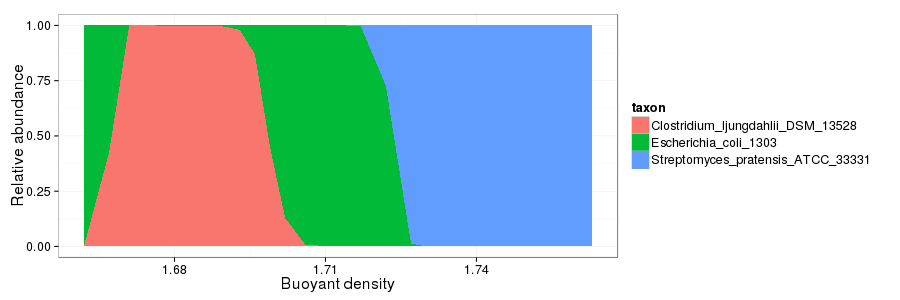

In [21]:
%%R -w 900 -h 300
ggplot(tbl.otu, aes(BD_mid, rel_abund, fill=taxon)) +
    geom_area(stat='identity') +
    labs(x = 'Buoyant density', y = 'Relative abundance') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

# Simulating PCR

* assuming 5 ng of DNA in a 30 ul rxn
  * Avg. MW of dNTPs = 499.5 g/mol
  * molarity of DNA in rxn = `5 * 1e-9 * (1 / 499.5) * (1 / (30 * 1e-6))`
* molarity of primers:
  * 1 uM (each)
* number of PCR cycles:
  * 30
*  
  
## Model from Suzuki MT & Giovannoni SJ (1996)
  
* equation for modeling increase in polymerized DNA conc.
  * $M = M_0 * e^{f*n}$
* equation for modeling rxn effeciency
  * $f(n) = f_0 * \big(\frac{P(n)}{k * M(n) + P(n)}\big)$
  
  
## algorithm

* deepcopy of OTU table object
  * perc_rel_abund = 0 (to be filled in later)
  * post_PCR_conc = 0 
* foreach column (fraction community) in OTU table:
  * select total start DNA from distribution
  * foreach taxon:
    * taxon_DNA_conc = rel_abund_perc / 100 * DNA_molarity
      * (starting DNA conc. for taxon) = M_0
    * foreach PCR cycle:
      * calculate effeciency (f)
      * calculate new concentration (M)
    * add to dataframe: post_PCR_conc
  * Normalize all post_PCR_conc by total sample conc
    * this is the new perc_rel_abund

In [15]:
otu_PCR_file = 'OTU_abs1e9_PCR.txt'

!cd $workDir; \
    SIPSim PCR \
    $otuTableFile \
    > $otu_PCR_file
    
!cd $workDir; \
    head -n 4 $otu_PCR_file

library	taxon	fraction	BD_min	BD_mid	BD_max	count	rel_abund	rel_abund_post_PCR
1	Clostridium_ljungdahlii_DSM_13528	1.660-1.664	1.66	1.662	1.664	0	0.0	0.0
1	Clostridium_ljungdahlii_DSM_13528	1.664-1.669	1.664	1.667	1.669	8266	0.425074565463	0.489348764347
1	Clostridium_ljungdahlii_DSM_13528	1.669-1.672	1.669	1.671	1.672	1643	1.0	1.0


In [22]:
%%R -i workDir -i otu_PCR_file
setwd(workDir) 

tbl.otu = read.delim(otu_PCR_file, sep='\t')
tbl.otu %>% head(n=3)

  library                             taxon    fraction BD_min BD_mid BD_max
1       1 Clostridium_ljungdahlii_DSM_13528 1.660-1.664  1.660  1.662  1.664
2       1 Clostridium_ljungdahlii_DSM_13528 1.664-1.669  1.664  1.667  1.669
3       1 Clostridium_ljungdahlii_DSM_13528 1.669-1.672  1.669  1.671  1.672
  count rel_abund rel_abund_post_PCR
1     0 0.0000000          0.0000000
2  8266 0.4250746          0.4893488
3  1643 1.0000000          1.0000000


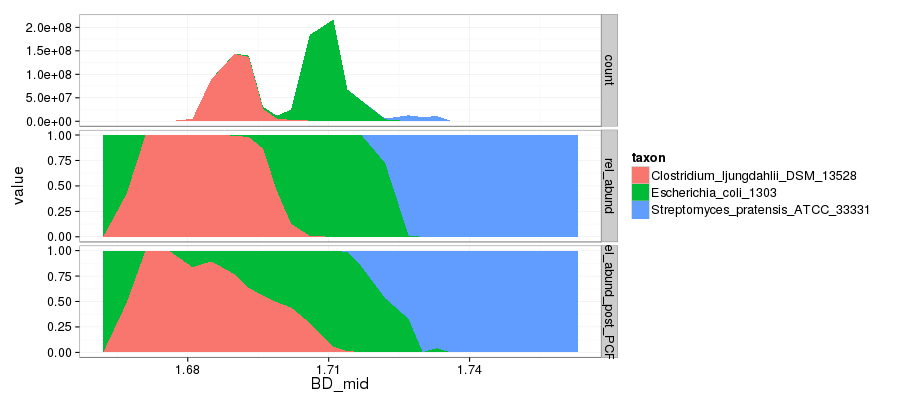

In [23]:
%%R -w 900 -h 400

tbl.otu.g = tbl.otu %>% gather('type', 'value', c(count, rel_abund, rel_abund_post_PCR))

ggplot(tbl.otu.g, aes(BD_mid, value, fill=taxon)) +
    geom_area() +
    facet_grid(type ~ ., scales='free_y') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

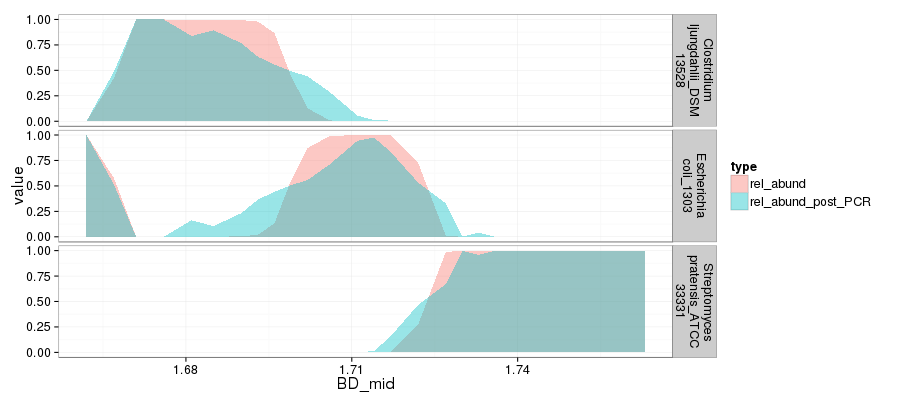

In [41]:
%%R -w 900 -h 400

tbl.otu.g = tbl.otu %>% gather('type', 'value', c(rel_abund, rel_abund_post_PCR))

tbl.otu.g$taxon = gsub('^([a-zA-Z0-9_]{10,15})_', '\\1\n', tbl.otu.g$taxon)
tbl.otu.g$taxon = gsub('\n([a-zA-Z0-9_]{10,15})_', '\n\\1\n', tbl.otu.g$taxon)

ggplot(tbl.otu.g, aes(BD_mid, value, fill=type)) +
    geom_area(position='dodge', alpha=0.4) +
    facet_grid(taxon ~ .) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

##